# Final Project for course 42578 Advanced Business Analytics

## Introduction

One of the main issues in e-commerce is the difficulty to understand the key of the success or the problems as a company. This kind of business requires a complex architecture that usually involves several kinds of customers, sellers, products or broad location coverage. In some cases, even with a good architecture, it is difficult to address the weakest points, as the number of variables can be immense.

Throughout this project, the Olist dataset is analyzed to understanding how Business Analytics can help on the comprehension of its situation, in order to create future strategies or develop hypotheses to reinforce their business.

### Imports

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
from unidecode import unidecode

%matplotlib inline
import matplotlib.pyplot as plt

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

Using TensorFlow backend.


In [2]:
customers = pd.read_csv('Olist/olist_customers_dataset.csv')
geolocation = pd.read_csv('Olist/olist_geolocation_dataset.csv')
order_items = pd.read_csv('Olist/olist_order_items_dataset.csv')
order_payments = pd.read_csv('Olist/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('Olist/olist_order_reviews_dataset.csv')
orders = pd.read_csv('Olist/olist_orders_dataset.csv')
products = pd.read_csv('Olist/olist_products_dataset.csv')
sellers = pd.read_csv('Olist/olist_sellers_dataset.csv')

!["titulo"](schema.jpeg)

## Dataset Analysis and preparation

### Orders dataset

In [3]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


In [3]:
orders['order_status'].nunique()

8

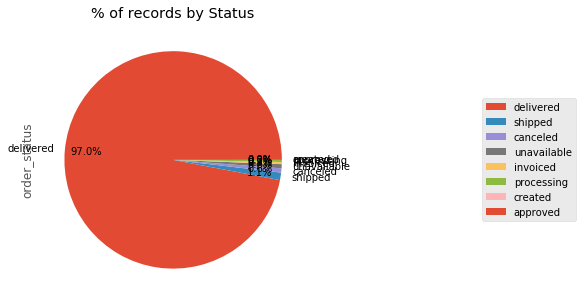

In [4]:
status = orders.order_status.value_counts()
status.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8, figsize=(7,5))
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of records by Status');

With almost all orders delivered, it will be our filter for our data, because the other possible categories would add a lot of 0 in our data that can affect the sensitivity on the analysis. Just in case, the format of all of them are transformed. If later is needed for data reduction, all but "delivered" would be removes.

In [5]:
#Dummies for the "order status" column
category_columns = ['order_status']
for col in category_columns:
    orders[col] = orders[col].astype('category')
orders = pd.get_dummies(orders, columns=category_columns)

In [6]:
# Change of date format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format="%Y-%m-%d %H:%M:%S")
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'], format="%Y-%m-%d %H:%M:%S")
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'], format="%Y-%m-%d %H:%M:%S")
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format="%Y-%m-%d %H:%M:%S")
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], format="%Y-%m-%d %H:%M:%S")

In [7]:
orders.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0,0,0,1,0,0,0,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,0,0,0,1,0,0,0,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0,0,0,1,0,0,0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,0,0,0,1,0,0,0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0,0,0,1,0,0,0,0


In [8]:
orders.describe()

,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
count,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000
mean,0.000020,0.006285,0.000050,0.970203,0.003158,0.003027,0.011132,0.006124
std,0.004485,0.079030,0.007091,0.170027,0.056104,0.054934,0.104921,0.078018
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Customers dataset

In [9]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Apart from using it as a link, considering our computational power and how much it would increase the categorical values, the customer_state variable will be the one taken from this dataset to add to the study.


In [10]:
cities = customers.customer_city.unique()

In [11]:
cities = customers.customer_city.value_counts()

In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


### Order reviews dataset

In [13]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [14]:
print('Number of different review_score: ', order_reviews['review_score'].nunique())

Number of different review_score:  5


In [15]:
#change of the date format
order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date'], format="%Y-%m-%d %H:%M:%S")
order_reviews['review_answer_timestamp'] = pd.to_datetime(order_reviews['review_answer_timestamp'], format="%Y-%m-%d %H:%M:%S")

In [16]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
review_id                  100000 non-null object
order_id                   100000 non-null object
review_score               100000 non-null int64
review_comment_title       11715 non-null object
review_comment_message     41753 non-null object
review_creation_date       100000 non-null datetime64[ns]
review_answer_timestamp    100000 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


This means that there are 42% orders with review, but only one 11.71% of reviews with a title

### Order payment dataset

In [17]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [18]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


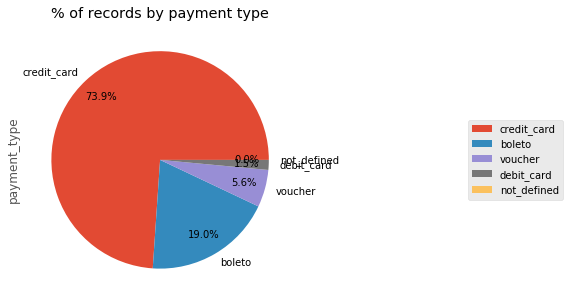

In [19]:
#Plot situation of the payment type
payment_type = order_payments.payment_type.value_counts()
payment_type.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8, figsize=(7,5))
plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of records by payment type');

In [20]:
#dummies for "payment type dummies"
category_columns = ['payment_type']
for col in category_columns:
    order_payments[col] = order_payments[col].astype('category')
order_payments = pd.get_dummies(order_payments, columns=category_columns)

In [21]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher
count,103886.000000,103886.000000,103886.000000,103886.00000,103886.000000,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380,0.19044,0.739224,0.014718,0.000029,0.055590
std,0.706584,2.687051,217.494064,0.39265,0.439060,0.120422,0.005374,0.229129
min,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,100.000000,0.00000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,171.837500,0.00000,1.000000,0.000000,0.000000,0.000000
max,29.000000,24.000000,13664.080000,1.00000,1.000000,1.000000,1.000000,1.000000


As it can be appreciated, "not_defined"  is a really small amount. Because of that, and as well because it cannot give any extra information to our model, the decision afterwards is to remove this records.

### Order items dataset

In [22]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [23]:
#date format change
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], format="%Y-%m-%d %H:%M:%S")

In [24]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 non-null object
order_item_id          112650 non-null int64
product_id             112650 non-null object
seller_id              112650 non-null object
shipping_limit_date    112650 non-null datetime64[ns]
price                  112650 non-null float64
freight_value          112650 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [25]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


This means that there are at least one order in which there is 21 items on them.

### Products dataset

In [26]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


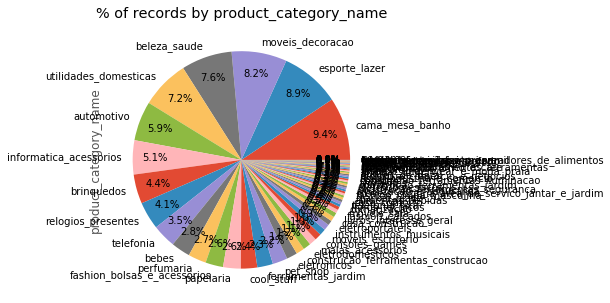

In [27]:
#plot of the product category
product_category_name = products.product_category_name.value_counts()
product_category_name.plot(kind='pie', autopct = '%1.1f%%', pctdistance = 0.8, figsize=(7,5))
#plt.legend(loc = "right", bbox_to_anchor = (1,0,1,1))
plt.title('% of records by product_category_name');

In [28]:
print('number of different product_category_name: ', products['product_category_name'].nunique())

number of different product_category_name:  73


As the plot indicates, there are too many categories to feed the system. Having 73 would mean that for feeding the network, the dummies would need to add before 73 columns more. For this reason, on the following data reduction, only the ones with a higher percentage will be taken for this analysis.

In [29]:
products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [30]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

It will be interesting to see how important is for the price and marketing the dimensions of the product and how it is announced (by photos, a good description or a precise title).

### Seller dataset

In [31]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


### Geolocation dataset

In [32]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [33]:
geolocation.geolocation_city.unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

In [34]:
print("the number of different cities is: ", geolocation.geolocation_city.nunique())
print("the number of different states is: ", geolocation.geolocation_state.nunique())

the number of different cities is:  8011
the number of different states is:  27


In [35]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
geolocation_zip_code_prefix    1000163 non-null int64
geolocation_lat                1000163 non-null float64
geolocation_lng                1000163 non-null float64
geolocation_city               1000163 non-null object
geolocation_state              1000163 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In this case, we find several problems on understanding the possible future problems of adding information from these dataset. The first of all is the big amount of categorical data from the column "city". Due to the computing capacity we would need to reduce this information to the "state" column. If we want to consider the state, latitude, longitud and the ZIP code can be a problem. This is becase the huge amount of different points for each of the states, that can lead to misinterpretation by the computer

### Merge datasets and drops

In [36]:
#Reduction of the amount of orders due to computing capacity
orders_small = orders.sample(n=20000, random_state=0) 

In [37]:
data = orders_small.merge(order_items, on=['order_id'], how='left')

In [38]:
data = data.merge(customers, on=['customer_id'], how='left')

In [39]:
data = data.merge(order_reviews, on=['order_id'], how='left')

In [40]:
data = data.merge(order_payments, on=['order_id'], how='left')

In [41]:
data = data.merge(products, on=['product_id'], how='left')

In [42]:
data = data.merge(sellers, on=['seller_id'],  how='left')

In [43]:
#Filtering only for the delivered records
data = data.loc[data['order_status_delivered'] == 1]

In [44]:
#drop of the order status
order_status_columns = ['order_status_approved', 'order_status_canceled',
       'order_status_created', 'order_status_delivered',
       'order_status_invoiced', 'order_status_processing',
       'order_status_shipped', 'order_status_unavailable']
data = data.drop(order_status_columns, axis=1)

In [45]:
#Filtering only for the defined payment type
data = data.loc[data['payment_type_not_defined'] == 0]

In [46]:
#drop of the column payment_type_not_defined
data = data.drop('payment_type_not_defined', axis=1)

In [47]:
#Extraction of the 10 most important categories
product_category_name = products.product_category_name.value_counts()
categories = product_category_name[:10].index
categories

Index(['cama_mesa_banho', 'esporte_lazer', 'moveis_decoracao', 'beleza_saude',
       'utilidades_domesticas', 'automotivo', 'informatica_acessorios',
       'brinquedos', 'relogios_presentes', 'telefonia'],
      dtype='object')

In [48]:
#Filtering only the most important categories
data = data.loc[data.product_category_name.isin(categories)] 

For understanding how our variables interact between each other, it is useful to look at the correlation matrix plot:

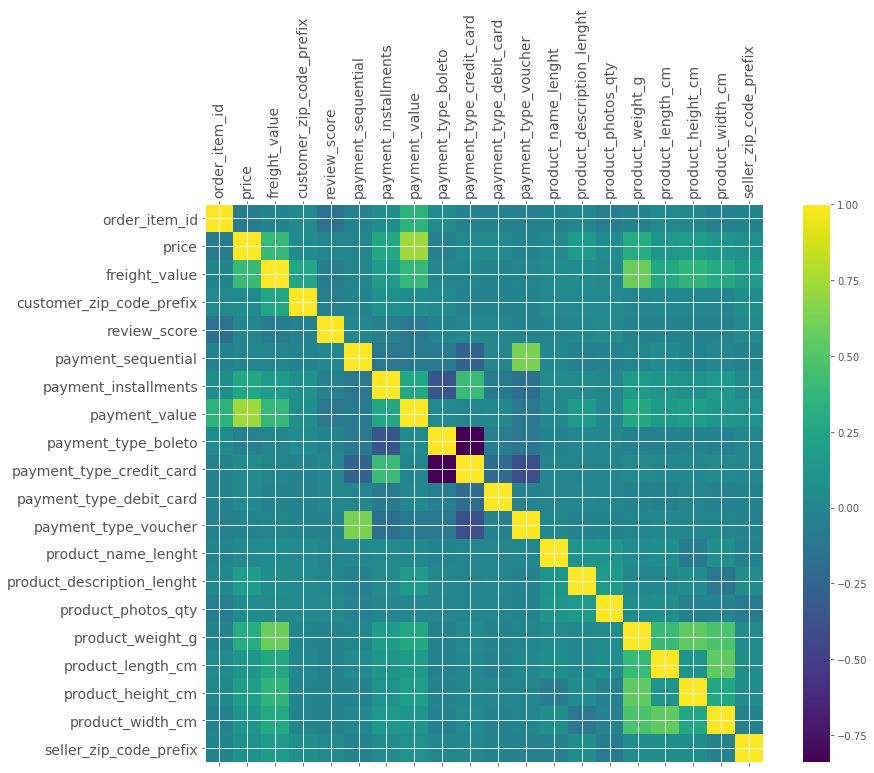

In [49]:
correlations = data.corr()
f = plt.figure(figsize=(14, 10))
plt.matshow(correlations, fignum=f.number)
plt.xticks(range(correlations.shape[1]), correlations.columns, fontsize=14, rotation = 90)
plt.yticks(range(correlations.shape[1]), correlations.columns, fontsize=14)
cb = plt.colorbar()

As we can see. all the relationships makes sense. Freight value is very related with the dimensions and weight of the product, and with the price. The dimensios of the products are very related between them. The payment type also gives information of combinations of them. 

In [50]:
#dummies for the categories of the product
data = pd.get_dummies(data, columns = ['product_category_name'])

In [51]:
#drops for city info
drops = ['customer_city', 'seller_city']
data = data.drop(drops, axis=1)

In [52]:
#dummies for the state variable
dummies = ['customer_state', 'seller_state']
data = pd.get_dummies(data, columns = dummies)

In [53]:
#drops of the comments dataset
reviews_comments_columns =['order_id', 'customer_id', 'order_purchase_timestamp', 'order_item_id', 'product_id', 'seller_id',
                           'review_id', 'review_score',
                           'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
reviews_comments_data = data[reviews_comments_columns]
drops = ['review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
data = data.drop(drops, axis=1)

In [54]:
data = data.dropna()

In [55]:
data = data.reset_index(drop = True)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14686 entries, 0 to 14685
Data columns (total 90 columns):
order_id                                        14686 non-null object
customer_id                                     14686 non-null object
order_purchase_timestamp                        14686 non-null datetime64[ns]
order_approved_at                               14686 non-null datetime64[ns]
order_delivered_carrier_date                    14686 non-null datetime64[ns]
order_delivered_customer_date                   14686 non-null datetime64[ns]
order_estimated_delivery_date                   14686 non-null datetime64[ns]
order_item_id                                   14686 non-null float64
product_id                                      14686 non-null object
seller_id                                       14686 non-null object
shipping_limit_date                             14686 non-null datetime64[ns]
price                                           14686 non-null float64
f

In [57]:
data.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,6b07198fae1bb61de16e845a92fc876f,92932704db71729a8f947b9ffdce4c99,2017-02-06 21:14:15,2017-02-06 21:25:13,2017-02-13 14:14:57,2017-02-17 12:11:59,2017-03-15,1.0,a1efe4a86746c22541813e22e1d23e33,da8622b14eb17ae2831f4ac5b9dab84a,...,0,0,0,0,0,0,0,0,0,1
1,66c8850e9f6bc2f81873165c41901706,b77e9f78e46a3fb8102d77740a2263da,2018-04-01 18:09:28,2018-04-01 18:27:51,2018-04-02 19:36:42,2018-04-03 12:22:34,2018-04-12,1.0,34e4f6bc7f4c44bdc0581b78aba124e1,1838dd9b8977065acf51d95e0053ea7a,...,0,0,0,0,0,0,0,0,0,0
2,c7ab4f518d1a47c3f78768c41c887d1b,f48f0e3bbe7fa6985141518b1d7264ce,2018-08-09 13:59:38,2018-08-11 02:55:27,2018-08-14 10:11:00,2018-08-27 20:04:23,2018-08-20,1.0,b7a812ed1b86b3b00e566dc29ba7ec7c,640e21a7d01df7614a3b4923e990d40c,...,0,0,0,0,0,0,0,0,0,1
3,0ff22bde315f6d0807028be76d9e736d,8125090a4744adfbe6d3940abeeb859b,2018-06-25 08:23:10,2018-06-27 09:11:47,2018-06-27 09:20:00,2018-07-05 12:36:25,2018-07-31,1.0,b75a056d7d03227c3a3b60e9ccf518c9,3f995f07c49d0d55a99d5c54957f7d81,...,0,0,0,0,0,0,0,0,0,1
4,5bbd189785115bc937623b13f25fcb78,e8f40c9ffd0d29d9176fcc2e97e8b29f,2018-03-19 23:53:36,2018-03-20 00:45:35,2018-03-22 20:48:48,2018-04-23 16:42:37,2018-04-12,1.0,7b67d49bc14fc6014038578cb4eca3cd,f12ff17ad8bbf01ec5c33b17e506649b,...,0,0,0,0,0,0,0,0,0,1


# Product quality analysis

One of the main issues of an e-commerce company is to address the dissatisfaction from the customers. It is one of the main attributes that evaluate some of the most important characteristics of the company, like their popularity, growth or customer trust. For this reason, it is so important to understand where are the weak points of the company in these terms and how they can solve these problems, or at least, to know which can be a potentially angry customer. The following study will be focused on predicting this issue, by predicting which would be the rating considering other inputs of the sell. This solution will allow the company to take actions for avoiding a situation where the reputation of the company can be damaged.

For implementing this solution, the target variable for the prediction will be the score from the customer ("review_score"). Throughout the project, several prediction models will be presented, analyzed and evaluated.

In [60]:
data2 = data.copy()

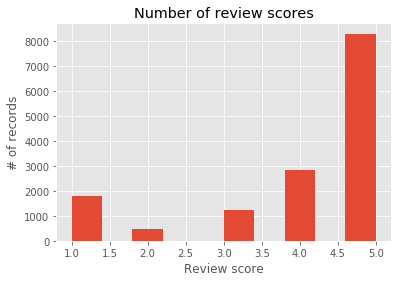

In [61]:
plt.hist(data['review_score'])
plt.title("Number of review scores")
plt.ylabel("# of records")
plt.xlabel("Review score");

As we can see, even the vast majority is satisfied, there are still a lot of bad reviews.

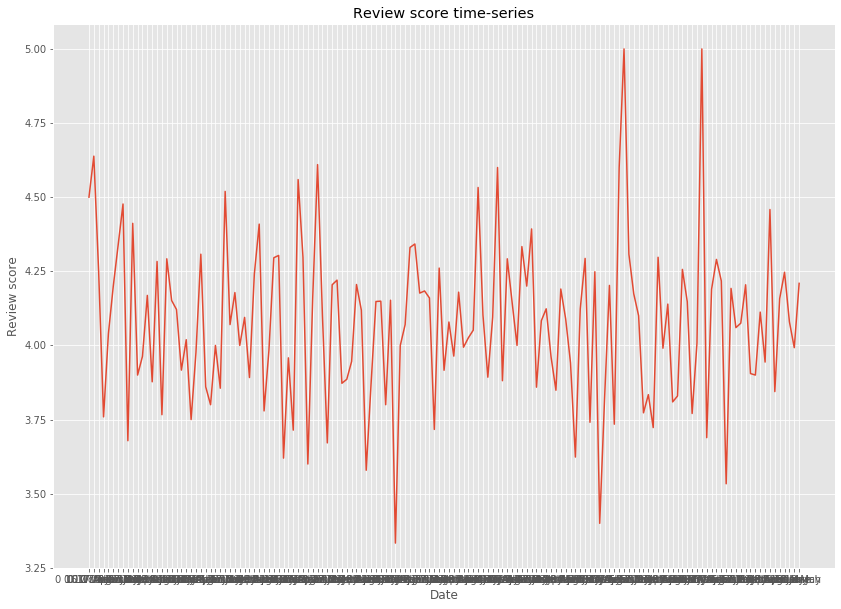

In [62]:
time_s = data2.groupby(data['order_purchase_timestamp'].dt.strftime('%w %y %B '))['review_score'].mean()
plt.figure(figsize=(14, 10))
plt.plot(time_s)
plt.ylabel('Review score')
plt.xlabel('Date')
plt.title("Review score time-series");

With this time-series graphic, for our dataset, we can see that apart of some peaks that are normal, is justified the usage of  the entire dataset in terms of timestamp.

### Dataset split: Train/validation/test

For selecting the variables used in this analysis, we have our focus in the following six areas:

    - Price of the product and the shipment
    - Payment type
    - Expectations: (how good is descripted the product will affect on the final output)
    - Dimensions of the product
    - Category of the product
    - Location of the customer and the seller(by state)

In [163]:
features_to_use = ['price', 'freight_value','payment_sequential','payment_installments','payment_value','payment_type_boleto',
'payment_type_credit_card','payment_type_debit_card','payment_type_voucher','product_name_lenght','product_description_lenght',
'product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','product_category_name_automotivo',
'product_category_name_beleza_saude','product_category_name_brinquedos','product_category_name_cama_mesa_banho',
'product_category_name_esporte_lazer','product_category_name_informatica_acessorios','product_category_name_moveis_decoracao',
'product_category_name_relogios_presentes','product_category_name_telefonia','product_category_name_utilidades_domesticas',
'customer_state_AC','customer_state_AL','customer_state_AM','customer_state_AP','customer_state_BA','customer_state_CE',
'customer_state_DF','customer_state_ES','customer_state_GO','customer_state_MA','customer_state_MG','customer_state_MS',
'customer_state_MT','customer_state_PA','customer_state_PB','customer_state_PE','customer_state_PI','customer_state_PR',
'customer_state_RJ','customer_state_RN','customer_state_RO','customer_state_RR','customer_state_RS','customer_state_SC',
'customer_state_SE','customer_state_SP','customer_state_TO','seller_state_BA','seller_state_CE',
'seller_state_DF','seller_state_ES','seller_state_GO','seller_state_MA','seller_state_MG','seller_state_MS','seller_state_MT',
'seller_state_PB','seller_state_PE','seller_state_PI','seller_state_PR','seller_state_RJ','seller_state_RN',
'seller_state_RS','seller_state_SC','seller_state_SE','seller_state_SP','seller_state_SC','seller_state_SE','seller_state_SP']

continuous_features_to_use = ['price', 'freight_value','payment_sequential','payment_installments','product_name_lenght','product_description_lenght',
'product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm' ]

target_variable = 'review_score'

In [64]:
#Shuffling for not allowing the order condition the results
data = data.sample(frac=1)

In [66]:
data = data.reset_index(drop=True)

In [164]:
train_perc = 0.5
val_perc = 0.2
split_point_1 = int(train_perc*len(data))
split_point_2 = int(val_perc*len(data))+split_point_1
X_train = data.loc[:split_point_1, features_to_use]
X_val = data.loc[(split_point_1+1):split_point_2, features_to_use]
X_test = data.loc[(split_point_2+1):, features_to_use]
y_train = data.loc[:split_point_1, target_variable]
y_val = data.loc[(split_point_1+1):split_point_2, target_variable]
y_test = data.loc[(split_point_2+1):, target_variable]

print("Num train records: %d" % len(X_train))
print("Num val records: %d" % len(X_val))
print("Num test records: %d" % len(X_test))

Num train records: 7344
Num val records: 2937
Num test records: 4405


##### Data standarization

For helping the model not to have biases because of the order of magnitude of the variables, is necessary to make an standarization for at least the continuous variables like in the following steps:

In [165]:
X_train_mean = X_train.loc[:,continuous_features_to_use].mean(axis=0)
X_train_std = X_train.loc[:,continuous_features_to_use].std(axis=0)
X_train.loc[:,continuous_features_to_use] = (X_train.loc[:,continuous_features_to_use] - X_train_mean) / X_train_std

X_val_mean = X_val.loc[:,continuous_features_to_use].mean(axis=0)
X_val_std = X_val.loc[:,continuous_features_to_use].std(axis=0)
X_val.loc[:,continuous_features_to_use] = (X_val.loc[:,continuous_features_to_use] - X_val_mean) / X_val_std

X_test_mean = X_test.loc[:,continuous_features_to_use].mean(axis=0)
X_test_std = X_test.loc[:,continuous_features_to_use].std(axis=0)
X_test.loc[:,continuous_features_to_use] = (X_test.loc[:,continuous_features_to_use] - X_test_mean) / X_test_std

# Prediction Models #

As an starting point, it has been decided to considered this prediction model as a classification problem. It is true, that it is not a real classification problem in which the bins for the score reviews have no numerical connection between them, but it is a good approximation. The issue is that with this approach, is that for example, the idea of having a "2" as a score review is not as bad as having a "1", will be lost. 

In any case, this model can fit really well with this approximation, because as it has been presented on the analysis, the main bins for this dataset, are the "1" and the "5" score. Having a continuous approximation, would mean that for evaluate its functionality, creating a range between 1 and 1.5 for a score of "1" will be smaller than 1.5 and 2.5 for a rate of "2". This, can create a bias in the result, as the main scores ("1" and "5") will have a smaller bins than the "not that relevant" ones ("2", "3", "4").

### Regular Classifiers

In [87]:
'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

In [166]:
from sklearn.svm import LinearSVC
#Creating a dict of the models
model_dict = {'SVC': LinearSVC(),
              'Logistic Regression': LogisticRegression(random_state=0),
              'Dummy' : DummyClassifier(random_state=0),
              'Random Forest': RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1),
              'Decision Tree': DecisionTreeClassifier(random_state=0),
              'AdaBoost': AdaBoostClassifier(random_state=0),
              'K Nearest Neighbor': KNeighborsClassifier()
              }

#Function to get the scores for each model in a df
def model_score_df(model_dict): 
    cont = 0
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():  
        print(cont)
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        cont+=1
    return model_comparison_df

model_score_df(model_dict)

0


C:\Users\guest\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class wi

1


C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2
3
4
5


C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


6


,model_name,accuracy_score,precision_score,recall_score,f1_score
3,Random Forest,0.616345,0.65198,0.340906,0.385265
4,Decision Tree,0.450624,0.319496,0.32663,0.322076
6,K Nearest Neighbor,0.478774,0.294901,0.263813,0.271697
2,Dummy,0.382293,0.189398,0.190408,0.189749
5,AdaBoost,0.567083,0.295158,0.210376,0.169321
1,Logistic Regression,0.569807,0.234056,0.208956,0.165514
0,SVC,0.568899,0.147249,0.200089,0.145606


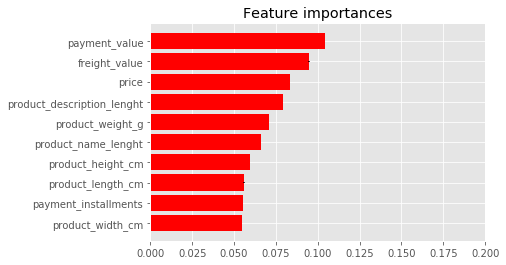

In [167]:
importances = model_dict['Random Forest'].feature_importances_
std = np.std([tree.feature_importances_ for tree in model_dict['Random Forest'].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.barh(range(10), importances[indices][:10][::-1],
       color="r", yerr=std[indices][:10][::-1],tick_label=np.array(features_to_use)[indices][:10][::-1],
       align="center")
plt.xlim([0, 0.2])
plt.show()

From the results we can easily see how difficult is to our model working with our dataset. Considering the Dummy classifier as the baseline, we can see that others like AdaBoost, the logistic regression or the Support Vector Machine. In this case, the Random Forest has gotten the best results on on all the different measures but it still has weak effectiveness.

Regarding the different features that are relevant to understanding the model, is remarkable that there are no location variables on the top 10. However, it seems that all the thing related to the price, is really important for the customer, something that is predictable, considering the human behaviour.

# Neural Network Models #

One step forward, would be the application of a neural network model. The capacity for understanding the different variables maybe will help to improve another aspects like the recall and f1 score

In [96]:
#As we will use the sparse categorical crossentropy is necessary to downgrade to 0 the first value of the target variables and in consequence, the rest of the values
y_train = y_train-1

In [97]:
y_val = y_val-1
y_test = y_test-1

We use sparse categorical function to avoid encoding the target variables in a one-hot encoding format.

In [99]:
# define the keras model
model = Sequential()
model.add(Dense(10,activation='relu',input_shape=(75,)))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(5,activation='softmax'))

# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=50, batch_size=128)


Train on 7344 samples, validate on 2937 samples
Epoch 1/50
7344/7344 [==============================] - 0s 40us/step - loss: 2.3458 - accuracy: 0.3122 - val_loss: 1.4376 - val_accuracy: 0.5506
Epoch 2/50
7344/7344 [==============================] - 0s 21us/step - loss: 1.3925 - accuracy: 0.5583 - val_loss: 1.3634 - val_accuracy: 0.5666
Epoch 3/50
7344/7344 [==============================] - 0s 21us/step - loss: 1.3089 - accuracy: 0.5611 - val_loss: 1.2782 - val_accuracy: 0.5649
Epoch 4/50
7344/7344 [==============================] - 0s 17us/step - loss: 1.2529 - accuracy: 0.5624 - val_loss: 1.2495 - val_accuracy: 0.5679
Epoch 5/50
7344/7344 [==============================] - 0s 15us/step - loss: 1.2347 - accuracy: 0.5635 - val_loss: 1.2394 - val_accuracy: 0.5669
Epoch 6/50
7344/7344 [==============================] - 0s 17us/step - loss: 1.2205 - accuracy: 0.5637 - val_loss: 1.2340 - val_accuracy: 0.5666
Epoch 7/50
7344/7344 [==============================] - 0s 15us/step - loss: 1.214

In [101]:
from sklearn.metrics import classification_report
target_names = ['Rating: 1', 'Rating: 2', 'Rating: 3','Rating: 4','Rating: 5']
y_pred = model.predict(X_test)


The argmax function is used to get the final model prediction, because the model outputs a 5-dimensional vector in the beggining (vector of probabilities), but we want the label with the highest probability or confidence score.

In [102]:
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Rating: 1       0.42      0.06      0.11       557
   Rating: 2       0.00      0.00      0.00       143
   Rating: 3       0.00      0.00      0.00       394
   Rating: 4       0.00      0.00      0.00       804
   Rating: 5       0.57      0.99      0.73      2507

    accuracy                           0.57      4405
   macro avg       0.20      0.21      0.17      4405
weighted avg       0.38      0.57      0.43      4405



C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In spite of lower results on accuracy and precision, the f1 score and the recall have improved a lot. This, it is as well for some trick of the neural network, because it has almost decided to just indicate the Ratings "1" and "5" as they are the most differenciable by far.

# Convolutional Neural Network #

Here we use a convolutional neural network to get the context of all the different features and then aggregate the extracted features using a max pooling operation that helps the neural network realize what the important features of our data are and perform better

In [103]:
#adjust de train,val and test for adding them as an input to the CNN
X_train2 = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1],1))

In [108]:
X_val2 = np.reshape(X_val.values, (X_val.shape[0], X_val.shape[1],1))
X_test2 = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1],1))

In [112]:
#As we can see, for using the variables as an input, is required to add another dim to them.
X_train2.shape

(7344, 75, 1)

In [113]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization

In [125]:
model = Sequential()
model.add(Conv1D(64,3,activation='relu',input_shape=(75,1,)))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(64,3,activation='relu',input_shape=(75,1,)))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(2))

model.add(Flatten())
model.add(Dense(5,activation='softmax'))

# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
history = model.fit(X_train2, y_train, validation_data = (X_val2,y_val), epochs=52, batch_size=128)

Train on 7344 samples, validate on 2937 samples
Epoch 1/52
7344/7344 [==============================] - 4s 580us/step - loss: 1.3173 - accuracy: 0.5379 - val_loss: 1.2385 - val_accuracy: 0.5560
Epoch 2/52
7344/7344 [==============================] - 3s 473us/step - loss: 1.2258 - accuracy: 0.5617 - val_loss: 1.2502 - val_accuracy: 0.5662
Epoch 3/52
7344/7344 [==============================] - 3s 436us/step - loss: 1.2230 - accuracy: 0.5630 - val_loss: 1.2296 - val_accuracy: 0.5666
Epoch 4/52
7344/7344 [==============================] - 3s 455us/step - loss: 1.2196 - accuracy: 0.5611 - val_loss: 1.2255 - val_accuracy: 0.5655
Epoch 5/52
7344/7344 [==============================] - 3s 464us/step - loss: 1.2133 - accuracy: 0.5632 - val_loss: 1.2196 - val_accuracy: 0.5686
Epoch 6/52
7344/7344 [==============================] - 3s 427us/step - loss: 1.2078 - accuracy: 0.5633 - val_loss: 1.2162 - val_accuracy: 0.5659
Epoch 7/52
7344/7344 [==============================] - 3s 432us/step - loss

In [127]:
from sklearn.metrics import classification_report

target_names = ['Rating: 1', 'Rating: 2', 'Rating: 3','Rating: 4','Rating: 5']
y_pred = model.predict(X_test2)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Rating: 1       0.38      0.18      0.24       557
   Rating: 2       0.21      0.04      0.07       143
   Rating: 3       0.24      0.04      0.07       394
   Rating: 4       0.25      0.11      0.15       804
   Rating: 5       0.59      0.87      0.71      2507

    accuracy                           0.54      4405
   macro avg       0.33      0.25      0.25      4405
weighted avg       0.46      0.54      0.47      4405



However we realize this is an underfitting scenario, so we should try another more complex neural network architectures.

In [128]:
model = Sequential()
model.add(Conv1D(64,3,activation='relu',input_shape=(75,1,)))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())

model.add(Conv1D(64,3,activation='relu'))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())

model.add(Conv1D(64,3,activation='relu'))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(5,activation='softmax'))

# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
history = model.fit(X_train2, y_train, validation_data = (X_val2,y_val), epochs=30, batch_size=128)

Train on 7344 samples, validate on 2937 samples
Epoch 1/30
7344/7344 [==============================] - 8s 1ms/step - loss: 1.2864 - accuracy: 0.5389 - val_loss: 1.4960 - val_accuracy: 0.4968
Epoch 2/30
7344/7344 [==============================] - 8s 1ms/step - loss: 1.2164 - accuracy: 0.5625 - val_loss: 1.4151 - val_accuracy: 0.5349
Epoch 3/30
7344/7344 [==============================] - 6s 780us/step - loss: 1.2090 - accuracy: 0.5650 - val_loss: 1.3515 - val_accuracy: 0.5386
Epoch 4/30
7344/7344 [==============================] - 6s 754us/step - loss: 1.2058 - accuracy: 0.5640 - val_loss: 1.3516 - val_accuracy: 0.5247
Epoch 5/30
7344/7344 [==============================] - 6s 787us/step - loss: 1.2005 - accuracy: 0.5656 - val_loss: 1.2571 - val_accuracy: 0.5526
Epoch 6/30
7344/7344 [==============================] - 5s 735us/step - loss: 1.1957 - accuracy: 0.5658 - val_loss: 1.2421 - val_accuracy: 0.5662
Epoch 7/30
7344/7344 [==============================] - 7s 950us/step - loss: 1.

In [129]:
from sklearn.metrics import classification_report

target_names = ['Rating: 1', 'Rating: 2', 'Rating: 3','Rating: 4','Rating: 5']
y_pred = model.predict(X_test2)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Rating: 1       0.37      0.19      0.26       557
   Rating: 2       0.36      0.06      0.11       143
   Rating: 3       0.25      0.14      0.18       394
   Rating: 4       0.25      0.23      0.24       804
   Rating: 5       0.61      0.77      0.68      2507

    accuracy                           0.52      4405
   macro avg       0.37      0.28      0.29      4405
weighted avg       0.47      0.52      0.48      4405



By adding complexity to our neural network, we have managed to have just slightly better results on the identification of the middle rates.

After playing with the different possibilities and considering the time use for it, the regular classifiers are still the best option.

# Regression and bins analysis #

On this part, we want to see which would be the difference if the prediction model is consider as an integer continuous variable. For comparing with the previous one, and considering that the rates must be integers, at the end there should be an operation of bin placement.

To start, a NN is used for the analysis:

In [131]:
model = Sequential()
model.add(Dense(100,activation='relu',input_shape=(75,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1))

# compile the keras model
model.compile(loss='mse', optimizer='rmsprop', metrics=['mse'])

# fit the keras model on the dataset
history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=100, batch_size=128)

Train on 7344 samples, validate on 2937 samples
Epoch 1/100
7344/7344 [==============================] - 0s 57us/step - loss: 57.9698 - mse: 57.9698 - val_loss: 64.1691 - val_mse: 64.1691
Epoch 2/100
7344/7344 [==============================] - 0s 32us/step - loss: 24.5969 - mse: 24.5969 - val_loss: 141.4425 - val_mse: 141.4425
Epoch 3/100
7344/7344 [==============================] - 0s 32us/step - loss: 20.0315 - mse: 20.0315 - val_loss: 70.3255 - val_mse: 70.3255
Epoch 4/100
7344/7344 [==============================] - 0s 30us/step - loss: 12.3642 - mse: 12.3642 - val_loss: 2.8792 - val_mse: 2.8792
Epoch 5/100
7344/7344 [==============================] - 0s 30us/step - loss: 7.9413 - mse: 7.9413 - val_loss: 2.4550 - val_mse: 2.4550
Epoch 6/100
7344/7344 [==============================] - 0s 27us/step - loss: 6.5030 - mse: 6.5030 - val_loss: 7.0672 - val_mse: 7.0672
Epoch 7/100
7344/7344 [==============================] - 0s 27us/step - loss: 4.0006 - mse: 4.0006 - val_loss: 2.4053 - 

In [132]:
y_pred_reg = model.predict(X_test)

In [133]:
#bin placement operation
y_pred=[]
for pred in y_pred_reg:
    if pred<0.5:
        y_pred.append(0)
    elif pred<1.5:
        y_pred.append(1)
    elif pred<2.5:
        y_pred.append(2)
    elif pred<3.5:
        y_pred.append(3)
    else:
        y_pred.append(4)

In [134]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Rating: 1       0.19      0.01      0.01       557
   Rating: 2       0.00      0.00      0.00       143
   Rating: 3       0.12      0.20      0.15       394
   Rating: 4       0.19      0.74      0.30       804
   Rating: 5       0.66      0.12      0.21      2507

    accuracy                           0.22      4405
   macro avg       0.23      0.21      0.13      4405
weighted avg       0.44      0.22      0.19      4405



As the results show, the model adapt better in precision, recall and f1 score to this way of analysis. Moreover, almost all the ratings but "2", are working better than the previous NN developed. However, this way of analysis loses a lot of accuracy compared with the other ones, something that can be affected to the division into different bins.

### MLP Regressor 

An MLP Regressor will be use to see its effectiveness:

In [136]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(10,), activation='tanh', max_iter=2000)
model.fit(X_train, y_train)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=2000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [137]:
y_pred_reg = model.predict(X_test)

In [138]:
y_pred=[]
for pred in y_pred_reg:
    if pred<0.5:
        y_pred.append(0)
    elif pred<1.5:
        y_pred.append(1)
    elif pred<2.5:
        y_pred.append(2)
    elif pred<3.5:
        y_pred.append(3)
    else:
        y_pred.append(4)

In [140]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Rating: 1       0.33      0.00      0.00       557
   Rating: 2       0.00      0.00      0.00       143
   Rating: 3       0.13      0.19      0.15       394
   Rating: 4       0.19      0.79      0.30       804
   Rating: 5       0.67      0.10      0.17      2507

    accuracy                           0.22      4405
   macro avg       0.26      0.22      0.13      4405
weighted avg       0.47      0.22      0.17      4405



As expected, the results show almost no difference compared with the previous NN.

# Feature Engineering #

One of the things that annoys more to the customers is when the company does not deliver on time the package. For this reason, we will implement a variable that calculate this impact.

In [149]:
data['date_diff'] = data['order_delivered_customer_date']-data['order_estimated_delivery_date']

In [150]:
data['diff_days_int'] = data['date_diff'].apply(lambda x: x.days)

In [151]:
data['diff_days_int'][:5]

0   -15
1   -34
2   -14
3    -2
4   -12
Name: diff_days_int, dtype: int64

In [152]:
features_to_use = ['price', 'freight_value','payment_sequential','payment_installments','payment_value','payment_type_boleto',
'payment_type_credit_card','payment_type_debit_card','payment_type_voucher','product_name_lenght','product_description_lenght',
'product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','product_category_name_automotivo',
'product_category_name_beleza_saude','product_category_name_brinquedos','product_category_name_cama_mesa_banho',
'product_category_name_esporte_lazer','product_category_name_informatica_acessorios','product_category_name_moveis_decoracao',
'product_category_name_relogios_presentes','product_category_name_telefonia','product_category_name_utilidades_domesticas',
'customer_state_AC','customer_state_AL','customer_state_AM','customer_state_AP','customer_state_BA','customer_state_CE',
'customer_state_DF','customer_state_ES','customer_state_GO','customer_state_MA','customer_state_MG','customer_state_MS',
'customer_state_MT','customer_state_PA','customer_state_PB','customer_state_PE','customer_state_PI','customer_state_PR',
'customer_state_RJ','customer_state_RN','customer_state_RO','customer_state_RR','customer_state_RS','customer_state_SC',
'customer_state_SE','customer_state_SP','customer_state_TO','seller_state_BA','seller_state_CE',
'seller_state_DF','seller_state_ES','seller_state_GO','seller_state_MA','seller_state_MG','seller_state_MS','seller_state_MT',
'seller_state_PB','seller_state_PE','seller_state_PI','seller_state_PR','seller_state_RJ','seller_state_RN',
'seller_state_RS','seller_state_SC','seller_state_SE','seller_state_SP','seller_state_SC','seller_state_SE','seller_state_SP','diff_days_int']

target_variable = 'review_score'

In [153]:
train_perc = 0.5
val_perc = 0.2
split_point_1 = int(train_perc*len(data))
split_point_2 = int(val_perc*len(data))+split_point_1
X_train = data.loc[:split_point_1, features_to_use]
X_val = data.loc[(split_point_1+1):split_point_2, features_to_use]
X_test = data.loc[(split_point_2+1):, features_to_use]
y_train = data.loc[:split_point_1, target_variable]
y_val = data.loc[(split_point_1+1):split_point_2, target_variable]
y_test = data.loc[(split_point_2+1):, target_variable]

print("Num train records: %d" % len(X_train))
print("Num val records: %d" % len(X_val))
print("Num test records: %d" % len(X_test))

Num train records: 7344
Num val records: 2937
Num test records: 4405


In [154]:
continuous_features_to_use = ['price', 'freight_value','payment_sequential','payment_installments','product_name_lenght','product_description_lenght',
'product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','diff_days_int' ]

X_train_mean = X_train.loc[:,continuous_features_to_use].mean(axis=0)
X_train_std = X_train.loc[:,continuous_features_to_use].std(axis=0)
X_train.loc[:,continuous_features_to_use] = (X_train.loc[:,continuous_features_to_use] - X_train_mean) / X_train_std

X_val_mean = X_val.loc[:,continuous_features_to_use].mean(axis=0)
X_val_std = X_val.loc[:,continuous_features_to_use].std(axis=0)
X_val.loc[:,continuous_features_to_use] = (X_val.loc[:,continuous_features_to_use] - X_val_mean) / X_val_std

X_test_mean = X_test.loc[:,continuous_features_to_use].mean(axis=0)
X_test_std = X_test.loc[:,continuous_features_to_use].std(axis=0)
X_test.loc[:,continuous_features_to_use] = (X_test.loc[:,continuous_features_to_use] - X_test_mean) / X_test_std

Let's run again our models but with this new feature that we think may be really important and explicative for the model response.

In [155]:
model_dict = {'SVC': LinearSVC(),
              'Logistic Regression': LogisticRegression(random_state=0),
              'Dummy' : DummyClassifier(random_state=0),
              'Random Forest': RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1),
              'Decsision Tree': DecisionTreeClassifier(random_state=0),
              'AdaBoost': AdaBoostClassifier(random_state=0),
              'K Nearest Neighbor': KNeighborsClassifier()
              }

#Function to get the scores for each model in a df
def model_score_df(model_dict): 
    cont = 0
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():  
        print(cont)
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        cont+=1
    return model_comparison_df

model_score_df(model_dict)

0


C:\Users\guest\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class wi

1


C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\guest\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2
3
4
5
6


,model_name,accuracy_score,precision_score,recall_score,f1_score
3,Random Forest,0.647446,0.700173,0.380804,0.429584
4,Decsision Tree,0.491487,0.348176,0.357986,0.35259
6,K Nearest Neighbor,0.491033,0.310965,0.268952,0.279076
5,AdaBoost,0.59546,0.243137,0.251706,0.224263
1,Logistic Regression,0.583201,0.267077,0.234389,0.204723
2,Dummy,0.382293,0.189398,0.190408,0.189749
0,SVC,0.184336,0.426746,0.206623,0.0950707


In [156]:
importances = model_dict['Random Forest'].feature_importances_

In [157]:
std = np.std([tree.feature_importances_ for tree in model_dict['Random Forest'].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

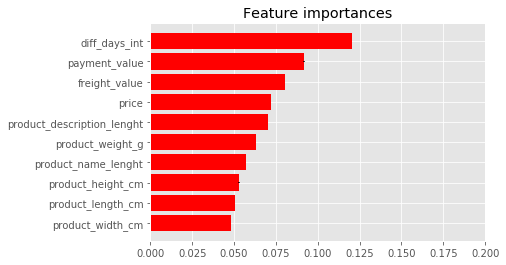

In [160]:
plt.figure()
plt.title("Feature importances")
plt.barh(range(10), importances[indices][:10][::-1],
       color="r", yerr=std[indices][:10][::-1],tick_label=np.array(features_to_use)[indices][:10][::-1],
       align="center")
plt.xlim([0, 0.2])
plt.show()

As we thought, not only this feature allow the models to perform better, but also it is consider the main value to determine which rating a buy has, as we have expose as an hypothesis.

# Network Analysis

Another way of getting information from all the orders this dataset provides, is by focusing in the tendencies that make sellers popular between the customers. For taking a look of this, a network analysis will be done to try to extract the top sellers, and after, check if there is any characteristics of the customers, products or something else that can give any information of why this is.

For this part, we will start loading the whole dataset again.

In [2]:
customers = pd.read_csv('Olist/olist_customers_dataset.csv')
geolocation = pd.read_csv('Olist/olist_geolocation_dataset.csv')
order_items = pd.read_csv('Olist/olist_order_items_dataset.csv')
order_payments = pd.read_csv('Olist/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('Olist/olist_order_reviews_dataset.csv')
orders = pd.read_csv('Olist/olist_orders_dataset.csv')
products = pd.read_csv('Olist/olist_products_dataset.csv')
sellers = pd.read_csv('Olist/olist_sellers_dataset.csv')

category_columns = ['order_status']
for col in category_columns:
    orders[col] = orders[col].astype('category')
orders = pd.get_dummies(orders, columns=category_columns)

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format="%Y-%m-%d %H:%M:%S")
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'], format="%Y-%m-%d %H:%M:%S")
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'], format="%Y-%m-%d %H:%M:%S")
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format="%Y-%m-%d %H:%M:%S")
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], format="%Y-%m-%d %H:%M:%S")

order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date'], format="%Y-%m-%d %H:%M:%S")
order_reviews['review_answer_timestamp'] = pd.to_datetime(order_reviews['review_answer_timestamp'], format="%Y-%m-%d %H:%M:%S")

category_columns = ['payment_type']
for col in category_columns:
    order_payments[col] = order_payments[col].astype('category')
order_payments = pd.get_dummies(order_payments, columns=category_columns)

order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], format="%Y-%m-%d %H:%M:%S")

data = orders.merge(order_items, on=['order_id'], how='left')

data = data.merge(customers, on=['customer_id'], how='left')

order_scores = order_reviews[['order_id', 'review_score']]

data = data.merge(products, on=['product_id'], how='left')

data = data.merge(sellers, on=['seller_id'],  how='left')

data = data.dropna()

In [3]:
seller_customer = ['seller_id', 'customer_unique_id']
net_data = data[seller_customer]

In [4]:
import networkx as nx

In [5]:
def get_digraph_from_df(df_g):
    G = nx.DiGraph() # directed graph
    for index, row in df_g.iterrows():
        sender = row['seller_id']
        recipient = row['customer_unique_id']
        G.add_edge(sender, recipient)
    return G

In [6]:
G = get_digraph_from_df(net_data)

print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 94996
Number of edges: 95527
Average in degree:   1.0056
Average out degree:   1.0056


This is the representation of all conections between sellers and customers of our dataset. The pourpose is to focus in customer that have bought from several sellers to see if there is any relationship between them, in order to asses new possible sellers on where to focus their market.

For doing so, customers that have done more than 3 orders from, at least, 3 different sellers will be selected.

In [7]:
customers_id = data.customer_unique_id.value_counts()

#Selection of customers that have done more than 3 orders
recurent_customers = customers_id.loc[customers_id > 3].index 

#Selection of customers that have done these orders from more than 3 different sellers
customers_to_use = []
for customer in recurent_customers:
    counts = data.loc[data.customer_unique_id == customer].seller_id.value_counts()
    if counts.size > 3:
        customers_to_use.append(customer)

data_copy = data.copy()

#New dataset 
data_copy = data_copy.loc[data_copy.customer_unique_id.isin(customers_to_use)]

data_copy = data_copy.reset_index(drop = True)

seller_customer = ['seller_id', 'customer_unique_id']

#Get data for the network
net_data = data_copy[seller_customer]

In [8]:
net_data

,seller_id,customer_unique_id
0,d1c281d3ae149232351cd8c8cc885f0d,0a609db8d244100909a15d65eadf8539
1,53e4c6e0f4312d4d2107a8c9cddf45cd,b8b3c435a58aebd788a477bed8342910
2,1e8b33f18b4f7598d87f5cbee2282cc2,7a380cb5434e6b6b5b37d45bb99dbe8a
3,4992e76a42cb3aad7a7047e0d3d7e729,7a380cb5434e6b6b5b37d45bb99dbe8a
4,6fd52c528dcb38be2eea044946b811f8,310647380793836bfa5b7b6b3f518423
...,...,...
324,4a3ca9315b744ce9f8e9374361493884,6a80a86f478a93a5f4c7ba8db6441a6b
325,da8622b14eb17ae2831f4ac5b9dab84a,6a80a86f478a93a5f4c7ba8db6441a6b
326,3d871de0142ce09b7081e2b9d1733cb1,35ecdf6858edc6427223b64804cf028e
327,1025f0e2d44d7041d6cf58b6550e0bfa,56c8638e7c058b98aae6d74d2dd6ea23


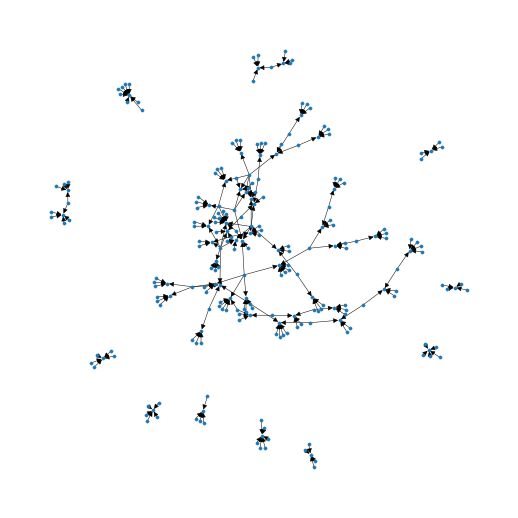

In [9]:
#Build the grph
G = get_digraph_from_df(net_data)

plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G.to_undirected()) # calculate positions of the nodes
options = {
    'node_size': 10,
    'width': 0.5
} # drawing options
nx.draw(G, pos=pos, **options)
plt.show()

In [10]:
from collections import Counter, OrderedDict
def get_top_centrality(G, func, top_n=10):
    degree_cent = func(G)
    degree_cent_ordered = OrderedDict(sorted(degree_cent.items(), 
                                             reverse=True, 
                                             key=lambda x: x[1])[:top_n])
    return degree_cent_ordered

When applying degree centrality it is possible to get the id of the sellers in the center of the network.

In [11]:
#sellers
dc_out_cent = get_top_centrality(G, nx.out_degree_centrality)
degree_cent = nx.out_degree_centrality(G)
colors = list(degree_cent.values())
dc_out_cent

OrderedDict([('1900267e848ceeba8fa32d80c1a5f5a8', 0.02953586497890295),
             ('1835b56ce799e6a4dc4eddc053f04066', 0.02953586497890295),
             ('da8622b14eb17ae2831f4ac5b9dab84a', 0.025316455696202528),
             ('53e4c6e0f4312d4d2107a8c9cddf45cd', 0.02109704641350211),
             ('4a3ca9315b744ce9f8e9374361493884', 0.016877637130801686),
             ('1c129092bf23f28a5930387c980c0dfc', 0.016877637130801686),
             ('4200ddf1967c5e41e48db62bc6d4b5ac', 0.012658227848101264),
             ('b2ba3715d723d245138f291a6fe42594', 0.012658227848101264),
             ('822166ed1e47908f7cfb49946d03c726', 0.012658227848101264),
             ('d1c281d3ae149232351cd8c8cc885f0d', 0.008438818565400843)])

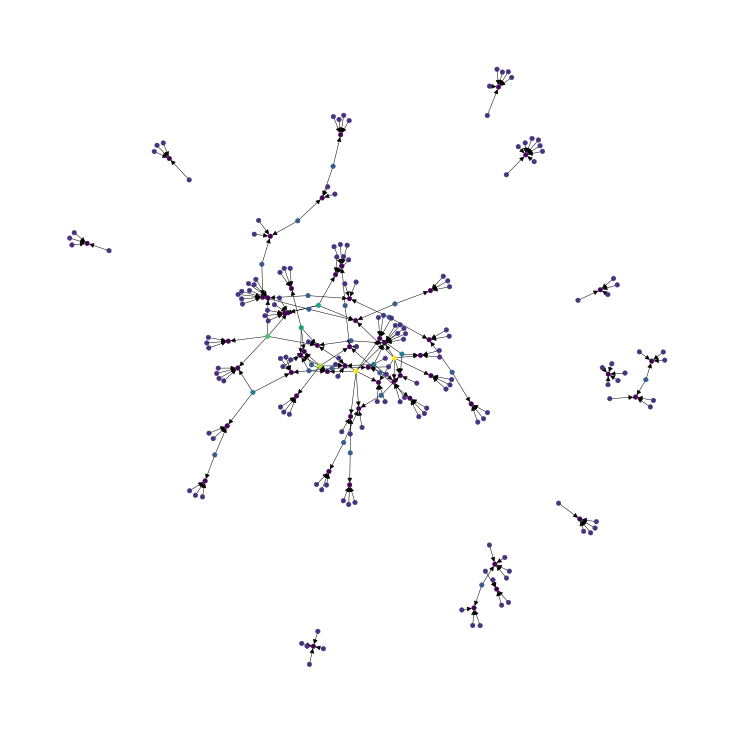

In [12]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G.to_undirected()) # calculate positions of the nodes
options = {
    'node_size': 20,
    'width': 0.5,
    'node_color': colors
} # drawing options
nx.draw(G, pos=pos, **options)
plt.show()

As easily can be seen with the colors, the most connected sellers are the ones in the middle of the network as mentioned above. Now, with a Design Structure Matrix let's try to see if there is any correlation between the different sellers and customers and we can get some clusters.

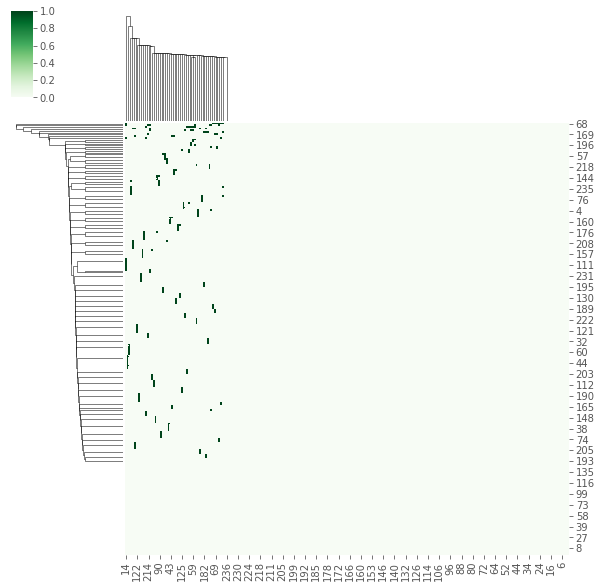

In [13]:
A = nx.to_numpy_matrix(G)
sns.clustermap(A, cmap=plt.cm.Greens);

Sadly, there are not very defined clusters. This means, by applying DSM we are not able to define any subset of characteristics of the sellers or customers that allow us to create any market targets.

Since only with the relationship between sellers and customers it is not possible to get any clusters, a new dataset with the top sellers found with the network analysis, but with all the features we have, will be used for clustering.

In [14]:
#List with the top seller ids
top_sellers = list(dc_out_cent.keys())

In [15]:
#Load all the variables and defne the dataset as at the begining of the notebook
data = orders.merge(order_items, on=['order_id'], how='left') #as we will sort by sellers, let's use all orders we are provided
data = data.merge(customers, on=['customer_id'], how='left')
data = data.merge(order_reviews, on=['order_id'], how='left')
data = data.merge(order_payments, on=['order_id'], how='left')
data = data.merge(products, on=['product_id'], how='left')
data = data.merge(sellers, on=['seller_id'],  how='left')
#Filtering only for the delivered records
data = data.loc[data['order_status_delivered'] == 1]
#drop of the order status
order_status_columns = ['order_status_approved', 'order_status_canceled',
       'order_status_created', 'order_status_delivered',
       'order_status_invoiced', 'order_status_processing',
       'order_status_shipped', 'order_status_unavailable']
data = data.drop(order_status_columns, axis=1)
#Filtering only for the defined payment type
data = data.loc[data['payment_type_not_defined'] == 0]
#drop of the column payment_type_not_defined
data = data.drop('payment_type_not_defined', axis=1)
#drops for city info
drops = ['customer_city', 'seller_city']
data = data.drop(drops, axis=1)
#drops of the comments dataset
drops = ['review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
data = data.drop(drops, axis=1)
data = data.dropna()
#as we will sort by sellers, let's keep all product categories for now
data_sellers = data.loc[data.seller_id.isin(top_sellers)]

### KMeans Clustering
The cluster method slected is KMeans. Despite we have some categorical variables, we will use only continuous variables since they are the ones that can give more information for clustering with KMeans. Also, we will normalize the data so all variables are comparable between them.

In [16]:
drops = ['product_category_name','customer_state', 'seller_state' ]
data_sellers = data_sellers.drop(drops, axis=1)

data_sellers = data_sellers.reset_index(drop = True)

features_to_use = ['order_purchase_timestamp', 'price', 'freight_value', 'review_score',
      'payment_sequential', 'payment_installments', 'payment_value',
      'product_name_lenght', 'product_description_lenght',
      'product_photos_qty', 'product_weight_g', 'product_length_cm',
      'product_height_cm', 'product_width_cm']

data_sellers = data_sellers[features_to_use]

data_sellers=data_sellers.set_index('order_purchase_timestamp')

data_sellers.head()

,price,freight_value,review_score,payment_sequential,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
order_purchase_timestamp,,,,,,,,,,,,,
2018-07-25 17:44:10,19.9,12.80,5,1.0,3.0,32.70,52.0,155.0,1.0,200.0,16.0,10.0,16.0
2017-04-20 20:42:44,38.5,24.84,4,1.0,5.0,63.34,53.0,223.0,1.0,950.0,45.0,15.0,35.0
2017-11-22 11:32:22,83.9,17.84,1,1.0,5.0,101.74,63.0,418.0,1.0,1500.0,45.0,15.0,35.0
2017-11-26 17:49:46,109.9,25.61,3,1.0,5.0,135.51,53.0,236.0,2.0,1975.0,41.0,13.0,31.0
2018-03-31 14:20:46,179.9,8.41,3,1.0,1.0,518.39,60.0,234.0,1.0,2050.0,34.0,8.0,32.0


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

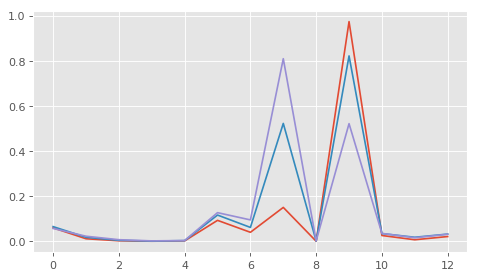

In [18]:
norm = Normalizer()
X = norm.fit_transform(data_sellers)

K=3
k=KMeans(K)
k.fit(X);

plt.figure(figsize=(7,4), dpi= 80)
x=range(13)
for c in k.cluster_centers_:
    plt.plot(x, c)

Variables that affect the decision of the clusters are 'Price', 'Payment value', 'Product name lenght', 'Product description lenght', 'Weight', 'Length' and 'Width'. Let's take a look of the distribution of the most informative variables.

In [19]:
cluster_variables = ['payment_value', 'product_description_lenght', 
 'product_weight_g']

clusters = k.fit_predict(X)

data_sellers['cluster'] = clusters

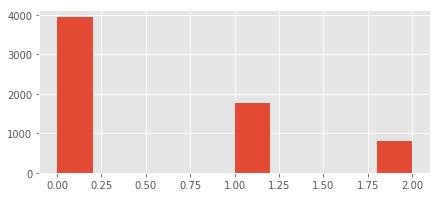

In [20]:
data_sellers.cluster.hist(figsize=(7,3));

##### Cluster 1

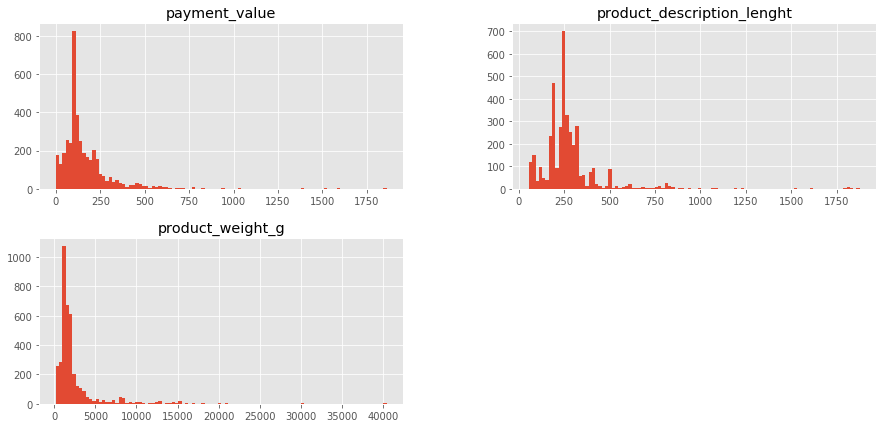

In [21]:
data_sellers.loc[data_sellers.cluster == 0][cluster_variables].hist(figsize=(15,7), bins = 100);

##### Cluster 2

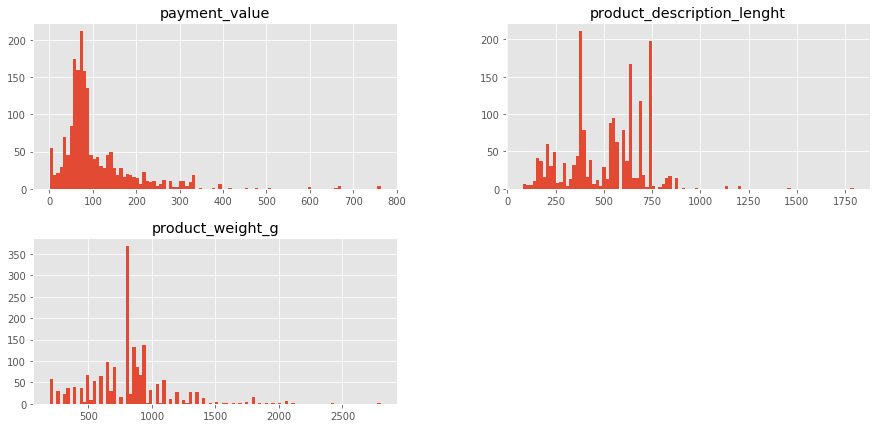

In [22]:
data_sellers.loc[data_sellers.cluster == 1][cluster_variables].hist(figsize=(15,7), bins = 100);

##### Cluster 3

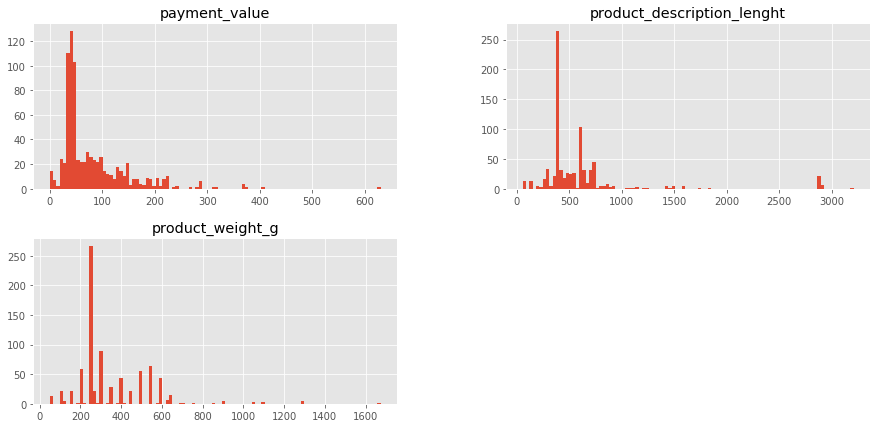

In [23]:
data_sellers.loc[data_sellers.cluster == 2][cluster_variables].hist(figsize=(15,7), bins = 100);

It is possible to say that for heavy products, what usually implies a higher value, the length of the description is normally not very long, around 250 words. For cheaper prices, and small and not very weighted products a longer product description is used by most connected sellers. 

## Conclusions


Stronger models is not always the best solution and it is what this study has proved. Customers on e-commerce are really conditioned by their expectations, normally pushed from what they see on the internet, so how good is announced on the website, but as well of how much they paid. In any case, receiving with a delay a purchase can ruin absolutely everything. For this reason, the main suggestion to the company from this study is to focus and reinforce their transport network, as it will be crutial for their success.

As it has been stated previously, the dataset has a clear bias on the high-grades by having a lot of records with this rating, something that is really negative for applying predictive models. Considered this and the obtained results, to improve and expand the study would be interesting for the company to separate the datasets in ratings and study the key for each of the scores that they received separately, so maybe they can get a deeper understanding.